# Осечки при стрельбе

Владелец тира заметил, что увеличилось количество жалоб на осечки при стрельбе из ружья. Осечка - это отсутствие выстрела при производстве стрельбы вследствие неисправности огнестрельного оружия или патрона. Инструкторы тира подтвердили, что примерно каждая пятая попытка выстрела заканчивается осечкой.

Решили проверить гипотезу о равенстве долей осечек при стрельбе патронами разных производителей. Поочерёдно будут заряжать по одному патрону от одного и от другого производителя и делать выстрел. Для каждого выстрела отмечать была осечка или нет. Уровень значимости и допустимая вероятность ошибки второго рода равны 0.1. Ожидаем, что доля осечек уменьшится с 0.2 до 0.1.

## Задание 1 (2 балла). Размеры групп

Сколько выстрелов нужно сделать патронами от каждого производителя, чтобы проверить гипотезу с заданными допустимыми вероятностями ошибок классическим способом (без техник последовательного тестирования)?

С помощью синтетических АА и АБ тестов проверьте, что для полученного размера групп вероятности ошибок контролируются на заданных уровнях.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from collections import defaultdict
import seaborn as sns

In [2]:
def get_sample_size(var1, var2, eff, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha)
    t_beta = stats.norm.ppf(1 - beta)
    disp_sum = var1 + var2
    sample_size = int(
        np.ceil(
            (t_alpha + t_beta) ** 2 * disp_sum / eff ** 2
        )
    )
    return sample_size

In [3]:
ALPHA = 0.1
BETA = 0.1
EFFECT = -0.1
p1 = 0.2
p2 = p1 + EFFECT
VAR_A = p1 * (1 - p1)
VAR_B = p2 * (1 - p2)

In [4]:
sample_size = get_sample_size(VAR_A, VAR_A, EFFECT, ALPHA, BETA)
print(sample_size)

211


Таким образом, нам нужно 211 сэмплов, или в нашем случае произвести 275 выстрелов, чтобы делать выводы о наличии эффекта.

In [5]:
def plot_pvalue_distribution_power(dict_pvalues, alpha=0.05):
    """Рисует графики распределения pvalue."""
    X = np.linspace(0, 1, 1000)
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues <= x) for x in X]
        prob_p = np.mean(np.array(pvalues) < alpha)
        plt.plot(X, Y, label=f'{key}, prob_p={prob_p:0.2f}')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

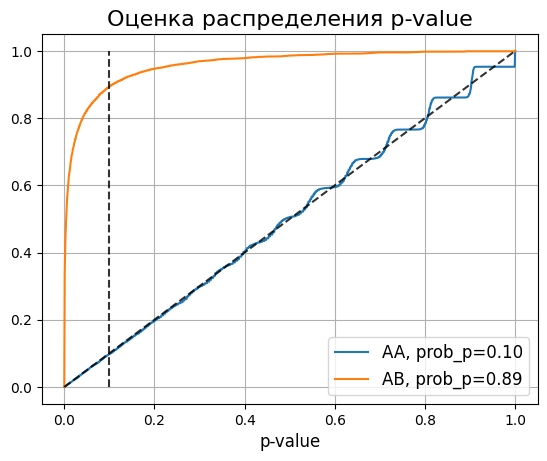

In [6]:
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size))
    b = np.random.binomial(1, p1 + EFFECT, sample_size)
    dict_pvalues['AA'].append(stats.ttest_ind(a_one, a_two).pvalue)
    dict_pvalues['AB'].append(stats.ttest_ind(a_one, b).pvalue)
plot_pvalue_distribution_power(dict_pvalues, alpha=ALPHA)

Как видим из графика, вероятности ошибок контролируются на заданных значениях.

## Задание 2 (3 балла). Критерий Вальда

Примените к этой задаче критерий Вальда. Можно взять функцию `test_sequential_wald` с семинара. Пока оставим приближение нормальным распределением в функциях `pdf_a` и `pdf_b`. Не забудьте скорректировать значения эффекта и std в параметрах распределений.

- Оцените вероятности ошибок первого и второго рода. Корректно ли работает критерий?
- Оцените средний размер групп до остановки теста.

In [7]:
def pdf_a(x):
    """Функция плотности разницы средних при верности нулевой гипотезы."""
    return stats.norm.pdf(x, 0, np.sqrt(2 * VAR_A))

def pdf_b(x):
    """Функция плотности разницы средних при верности альтернативной гипотезы."""
    return stats.norm.pdf(x, EFFECT, np.sqrt(VAR_A + VAR_B))

def test_sequential_wald(a, b, pdf_a, pdf_b, alpha, beta):
    """Проводим последовательное тестирование критерием Вальда.

    a, b - данные контрольной и экспериментальной групп
    pdf_a, pdf_b - функции плотности распределения при нулевой и альтернативной гипотезах
    alpha, beta - допустимые вероятности ошибок первого и второго рода

    return:
        - decision: 0 - незначимые отличия, 1 - значимые отличия, 0.5 - границы не пересечены
        - length - кол-во объектов при принятии решения
    """
    size = len(a)
    lower_bound = np.log(beta / (1 - alpha))
    upper_bound = np.log((1 - beta) / alpha)

    deltas = b - a
    pdf_a_values = pdf_a(deltas)
    pdf_b_values = pdf_b(deltas)
    z = np.cumsum(np.log(pdf_b_values / pdf_a_values))
    
    indexes_lower = np.arange(size)[z < lower_bound]
    indexes_upper = np.arange(size)[z > upper_bound]
    first_index_lower = indexes_lower[0] if len(indexes_lower) > 0 else size + 1
    first_index_upper = indexes_upper[0] if len(indexes_upper) > 0 else size + 1

    if first_index_lower < first_index_upper:
        return 0, first_index_lower + 1
    elif first_index_lower > first_index_upper:
        return 1, first_index_upper + 1
    else:
        return 0.5, size

In [8]:
sample_size_ = 500
dict_res = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size_))
    b = np.random.binomial(1, p1 + EFFECT, sample_size_)
    dict_res['AA'].append(test_sequential_wald(a_one, a_two, pdf_a, pdf_b, ALPHA, BETA)[0])
    dict_res['AB'].append(test_sequential_wald(a_one, b, pdf_a, pdf_b, ALPHA, BETA)[0])

for k, v in dict_res.items():
    print(k, np.mean(v))

  0%|          | 0/5000 [00:00<?, ?it/s]

AA 0.1064
AB 0.9216


Как видим, pvalue AA теста примерно 0.1, а мощность при AB тесте около 0.9. Соотносится с теми заданными значениями уровня занчимости и вероятностью ошибки 2 рода, которые мы задали.

  0%|          | 0/10000 [00:00<?, ?it/s]

sample_size = 211
mean length AA = 53.2
mean length AB = 61.4


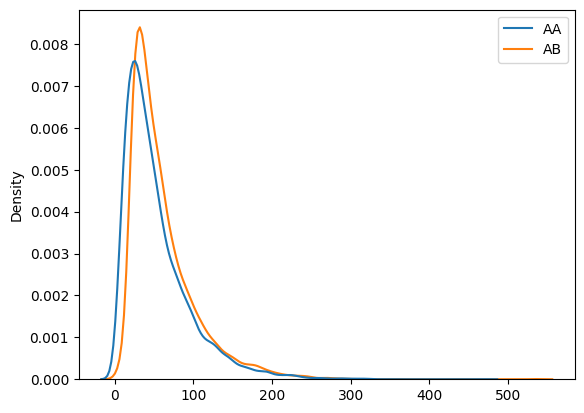

In [9]:
sample_size_ = 1000
dict_lengths = defaultdict(list)
for _ in tqdm(range(10000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size_))
    b = np.random.binomial(1, p1 + EFFECT, sample_size_)
    dict_lengths['AA'].append(test_sequential_wald(a_one, a_two, pdf_a, pdf_b, ALPHA, BETA)[1])
    dict_lengths['AB'].append(test_sequential_wald(a_one, b, pdf_a, pdf_b, ALPHA, BETA)[1])
print(F'sample_size = {sample_size}')

for k, v in dict_lengths.items():
    print(f'mean length {k} = {np.mean(v):0.1f}')
sns.kdeplot(data=dict_lengths)
plt.show()

По графику видно, что в среднем тесты длились гораздо меньше, чем при классическом тесте, примерно в 4 раза меньше.

## Задание 3 (3 балла). Разность бернуллиевских СВ

Замените приближение нормальным распределением в функциях `pdf_a` и `pdf_b` на их аналоги для разности двух бернуллиевских случайных величин. Повторите эксперименты из задания 2.

- Оцените вероятности ошибок первого и второго рода. Корректно ли работает критерий?
- Оцените средний размер групп до остановки теста.

Допустим у нас есть разница бернуллиевских случайных величин:

$$X_1 - X_2$$

с вероятностями успеха $p_1, p_2$ соответсвенно. Случайные величини принимают значения -1($X_1 = 0, X_2=1$),0($X_1=X_2=0$ или $X_1=X_2=1$) или 1($X_1=1, X_2=0$).

$$-1: (1-p_1)*p_2 \\
0: p_1*p_2 + (1-p_1)*(1-p_2) \\
1: p_1 * (1-p_2)$$

In [10]:
def pdf_a_bernoulli(x):
    """Функция плотности разницы средних при верности нулевой гипотезы."""
    pdfs = np.zeros_like(x, dtype=float)
    pdfs[x == 0] = p1**2 + (1-p1)**2
    pdfs[x != 0] = p1 * (1-p1)
    return pdfs

def pdf_b_bernoulli(x):
    """Функция плотности разницы средних при верности альтернативной гипотезы."""
    pdfs = np.zeros_like(x, dtype=float)
    pdfs[x == 0] = p1*p2 + (1-p1)*(1-p2)
    pdfs[x == -1] = p1 * (1-p2)
    pdfs[x == 1] = p2 * (1-p1)
    return pdfs

In [11]:
sample_size_ = 500
dict_res = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size_))
    b = np.random.binomial(1, p1 + EFFECT, sample_size_)
    dict_res['AA'].append(test_sequential_wald(a_one, a_two, pdf_a_bernoulli, pdf_b_bernoulli, ALPHA, BETA)[0])
    dict_res['AB'].append(test_sequential_wald(a_one, b, pdf_a_bernoulli, pdf_b_bernoulli, ALPHA, BETA)[0])

for k, v in dict_res.items():
    print(k, np.mean(v))

  0%|          | 0/5000 [00:00<?, ?it/s]

AA 0.0964
AB 0.9176


  0%|          | 0/10000 [00:00<?, ?it/s]

sample_size = 211
mean length AA = 58.3
mean length AB = 66.4


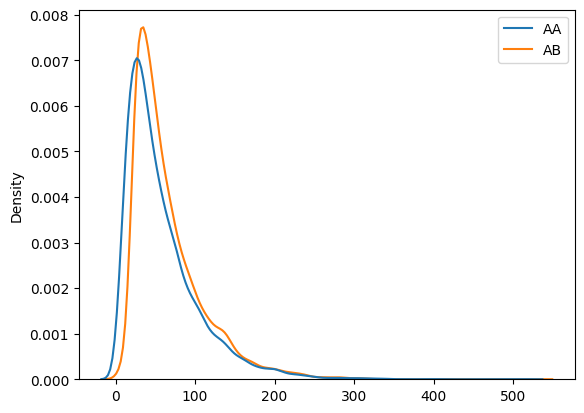

In [12]:
sample_size_ = 1000
dict_lengths = defaultdict(list)
for _ in tqdm(range(10000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size_))
    b = np.random.binomial(1, p1 + EFFECT, sample_size_)
    dict_lengths['AA'].append(test_sequential_wald(a_one, a_two, pdf_a_bernoulli, pdf_b_bernoulli, ALPHA, BETA)[1])
    dict_lengths['AB'].append(test_sequential_wald(a_one, b, pdf_a_bernoulli, pdf_b_bernoulli, ALPHA, BETA)[1])
print(F'sample_size = {sample_size}')

for k, v in dict_lengths.items():
    print(f'mean length {k} = {np.mean(v):0.1f}')
sns.kdeplot(data=dict_lengths)
plt.show()

Судя по вероятностям ошибок 1 и 2 рода, метод тоже работает. Разве что мощность подросла немного. Среднее количество испытаний также меньше, чем при классическом тесте, однако чуть больше, чем в варианте с апроксимацией нормальным распределением. 

## Задание 4 (2 балла). Сравнение методов

Сравните подходы из 2-го и 3-го заданий. У кого больше вероятность ошибки первого рода, вероятность ошибки второго рода, среднее количество размеров групп? Отличия статистически значимые?

In [13]:
sample_size_ = 500
dict_res = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size_))
    b = np.random.binomial(1, p1 + EFFECT, sample_size_)
    dict_res['AA'].append(test_sequential_wald(a_one, a_two, pdf_a, pdf_b, ALPHA, BETA)[0])
    dict_res['AB'].append(test_sequential_wald(a_one, b, pdf_a, pdf_b, ALPHA, BETA)[0])

for k, v in dict_res.items():
    print(k, np.mean(v))

  0%|          | 0/5000 [00:00<?, ?it/s]

AA 0.1084
AB 0.9154


In [14]:
sample_size_ = 500
dict_res_bern = defaultdict(list)
for _ in tqdm(range(5000)):
    a_one, a_two = np.random.binomial(1, p1, (2, sample_size_))
    b = np.random.binomial(1, p1 + EFFECT, sample_size_)
    dict_res_bern['AA'].append(test_sequential_wald(a_one, a_two, pdf_a_bernoulli, pdf_b_bernoulli, ALPHA, BETA)[0])
    dict_res_bern['AB'].append(test_sequential_wald(a_one, b, pdf_a_bernoulli, pdf_b_bernoulli, ALPHA, BETA)[0])

for k, v in dict_res_bern.items():
    print(k, np.mean(v))

  0%|          | 0/5000 [00:00<?, ?it/s]

AA 0.0922
AB 0.9212


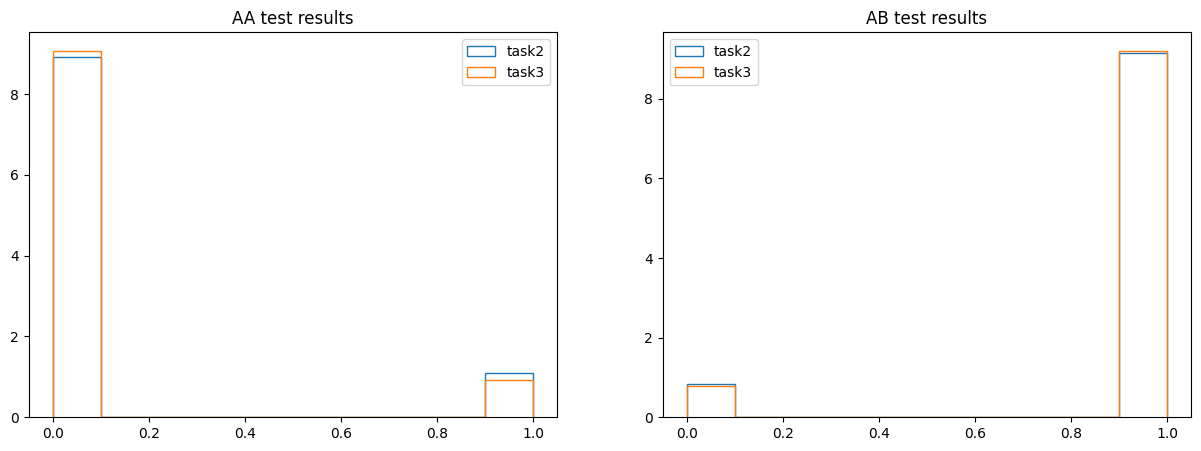

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(dict_res['AA'], density=True, histtype='step', label='task2')
axes[0].hist(dict_res_bern['AA'], density=True, histtype='step', label='task3')
axes[0].set_title('AA test results')
axes[0].legend()

axes[1].hist(dict_res['AB'], density=True, histtype='step', label='task2')
axes[1].hist(dict_res_bern['AB'], density=True, histtype='step', label='task3')
axes[1].set_title('AB test results')
axes[1].legend()

plt.show()

Как видим, метод из таска 3 немного более точен. Вероятность ошибки 2 рода немного меньше, как и вероятность ошибки 1 рода. Но кажется не статистически значимо, разница небольшая.

Что касается времени проведения экспериментов, тот тут разница в 10% процентов что для AA, что для AB тестов. Как видим из результатов, для АА тестов из 2 задания, среднее время 53.6(кол-во наблюдений), в то время как для 3 задания - 58. Для AB тестов тоже есть разница - 61 против 66 наблюдений. Таким образом, уже можно говорить, что в случае 2 задания, время для принятия решения действительно несколько меньше в среднем. Однако распределения выглядят очень похоже.